# Imports

In [1]:
from IPython.display import clear_output

In [2]:
!pip install transformers datasets
!pip install --upgrade accelerate
# !pip install --upgrade transformers
clear_output()

In [3]:
import torch
from IPython.display import clear_output
from transformers import AutoTokenizer, RobertaModel, RobertaForSequenceClassification, RobertaTokenizer
import torch.nn as nn
from transformers import get_scheduler
from tqdm.notebook import tqdm
from datasets import load_metric, load_dataset
from transformers import TrainingArguments, Trainer
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
checkpoint = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
roberta_model = RobertaForSequenceClassification.from_pretrained(checkpoint, num_labels=2).to(device)
clear_output()

In [ ]:
roberta_model

# Dataset

In [7]:
dataset = load_dataset("rotten_tomatoes")

# dataset_ratio = 10
# train_ds = load_dataset("imdb", split="train[:10%]+train[-10%:]")
# test_ds = load_dataset("imdb", split="train[:10%]+train[-10%:]")

clear_output()

In [8]:
# Create a smaller training dataset for faster training times
small_train_dataset = dataset["train"].shuffle(seed=42)
small_test_dataset = dataset["test"]

In [9]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_train = small_train_dataset.map(tokenize_function, batched=True)
tokenized_test = small_test_dataset.map(tokenize_function, batched=True)

clear_output()

In [10]:
tokenized_train.set_format("torch",columns=["input_ids", "attention_mask", "label"])
tokenized_test.set_format("torch",columns=["input_ids", "attention_mask", "label"])

In [11]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Trainer


In [12]:
# Define the evaluation metrics
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")
    load_precision = load_metric('precision')
    load_recall = load_metric('recall')

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    precision = load_precision.compute(predictions=predictions, references=labels)["precision"]
    recall = load_recall.compute(predictions=predictions, references=labels)["recall"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1, 'precision': precision, 'recall': recall}

In [13]:
training_args = TrainingArguments(
    output_dir='./roberta',
    # learning_rate=0.1,
    #  weight_decay=0.01,
    # optim = "adamw_torch",
    per_device_train_batch_size=4,
    per_device_eval_batch_size = 4,
    num_train_epochs=1,

    save_strategy="epoch",
    logging_steps=64,
    save_steps=512,
    overwrite_output_dir=True,
    save_total_limit=10,
    # push_to_hub=True,
)

trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    # optimizers=optim, scheduler
)

In [14]:

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
64,0.712900
128,0.671300
192,0.709400
256,0.702400
320,0.749700
384,0.699100
448,0.714400
512,0.672700
576,0.666900
640,0.660600


TrainOutput(global_step=2133, training_loss=0.6262076856717782, metrics={'train_runtime': 218.6855, 'train_samples_per_second': 39.006, 'train_steps_per_second': 9.754, 'total_flos': 170691241609680.0, 'train_loss': 0.6262076856717782, 'epoch': 1.0})

In [16]:
# Compute the evaluation metrics
trainer.evaluate()

{'eval_loss': 0.6232614517211914,
 'eval_accuracy': 0.8452157598499062,
 'eval_f1': 0.8367952522255194,
 'eval_precision': 0.8849372384937239,
 'eval_recall': 0.7936210131332082,
 'eval_runtime': 5.3238,
 'eval_samples_per_second': 200.232,
 'eval_steps_per_second': 50.152,
 'epoch': 1.0}

# Integrated Gradient

In [17]:
# training parameters
batch_size = 1
lr = 0.1
epochs = 1

In [18]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_train, shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

test_dataloader = DataLoader(
    tokenized_test, batch_size=batch_size, collate_fn=data_collator, shuffle=True
)

In [19]:
def compute_integrated_gradient(batch_x, batch_blank, model, idx, steps):
    mean_grad = 0
    n = steps

    for i in range(1, n + 1):
        x =  i / n * (batch_x)

        y = model(inputs_embeds=x,  output_hidden_states=True)

        grads =[0]*len(y.hidden_states)
        for j in range(len(y.hidden_states)):

            (grad,) = torch.autograd.grad(y.logits[0][idx], y.hidden_states[j],  retain_graph=True)
            grads[j] += grad / n
    # print(grads)
    hidden_states = torch.cat(y.hidden_states, dim=0)
    grads = torch.cat(grads, dim=0)
    # print(hidden_states.shape, grads.shape)
    integrated_gradients = hidden_states *  grads
    integrated_gradients = torch.norm(integrated_gradients, p=2, dim=-1)
    # print(integrated_gradients.shape)
    return integrated_gradients

  0%|          | 0/10 [00:00<?, ?it/s]

{'text': 'lovingly photographed in the manner of a golden book sprung to life , stuart little 2 manages sweetness largely without stickiness .', 'label': 1}
----------------------------------------


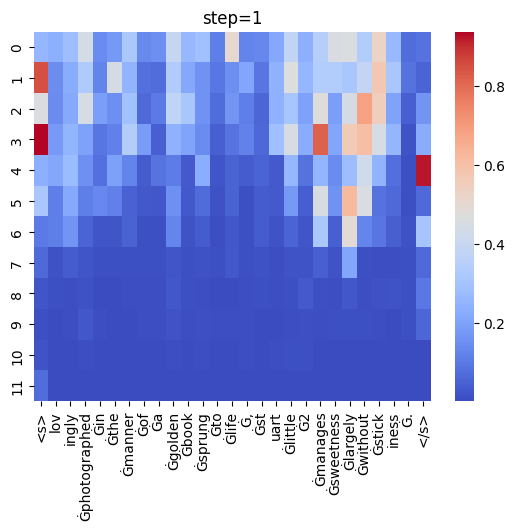

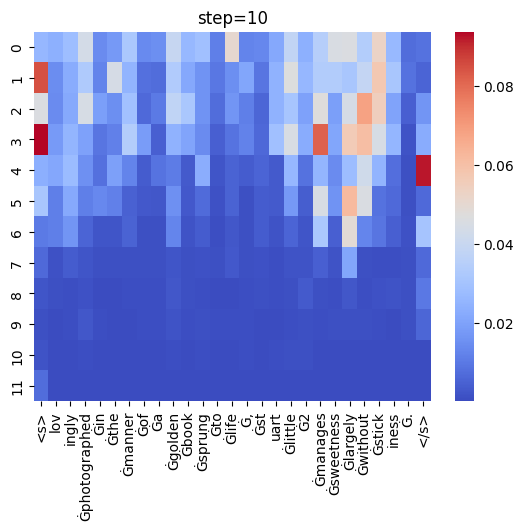

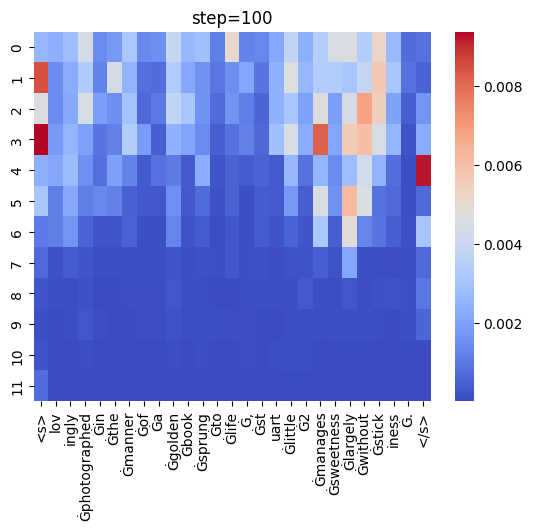

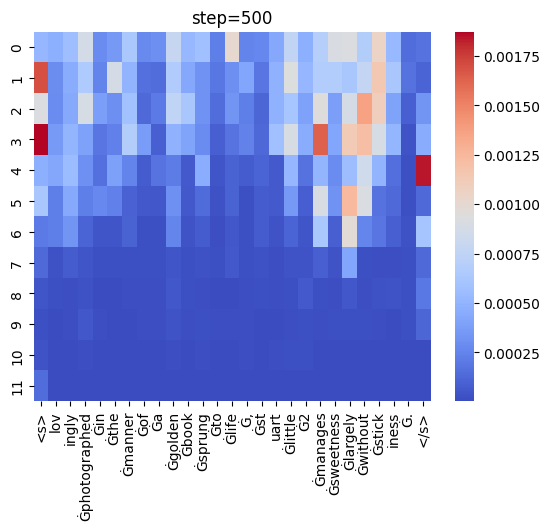

{'text': 'consistently clever and suspenseful .', 'label': 1}
----------------------------------------


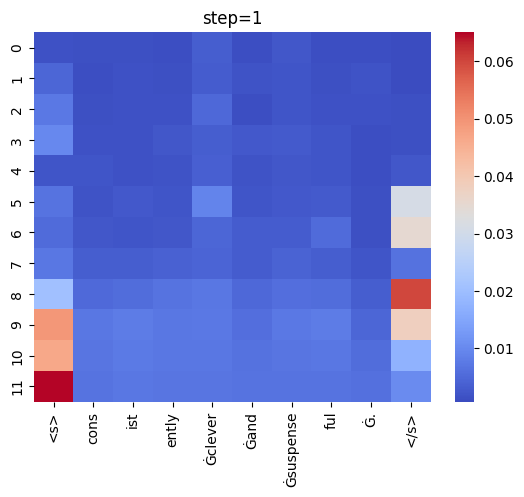

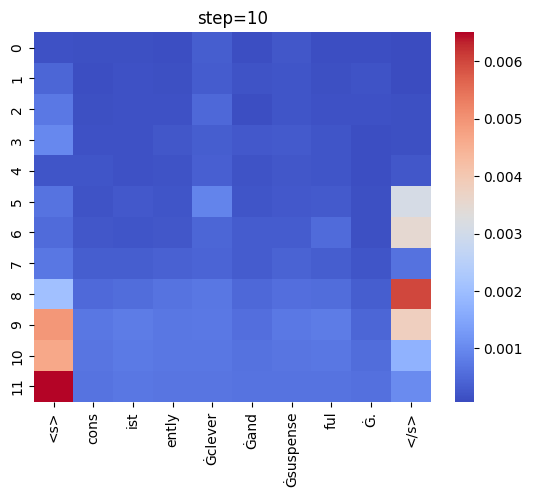

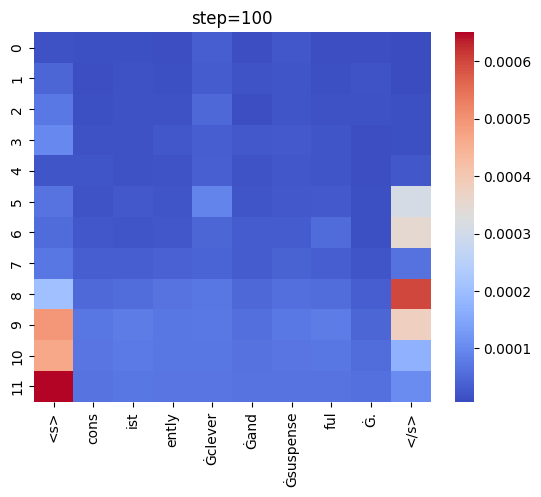

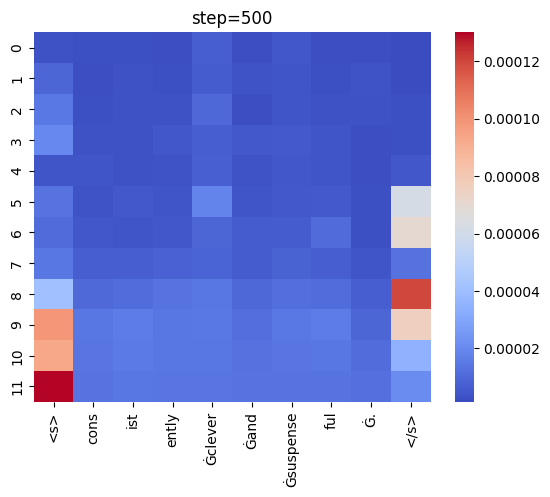

{'text': 'it\'s like a " big chill " reunion of the baader-meinhof gang , only these guys are more harmless pranksters than political activists .', 'label': 1}
----------------------------------------


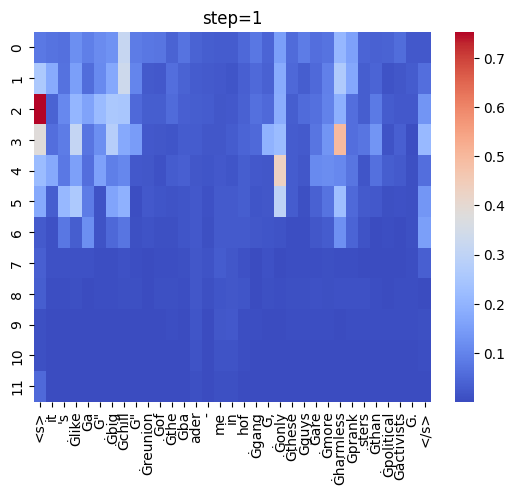

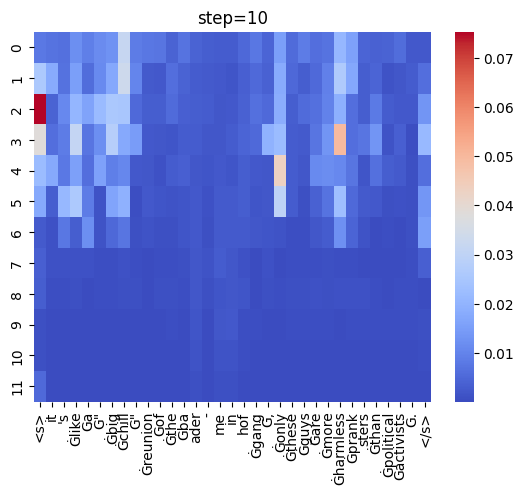

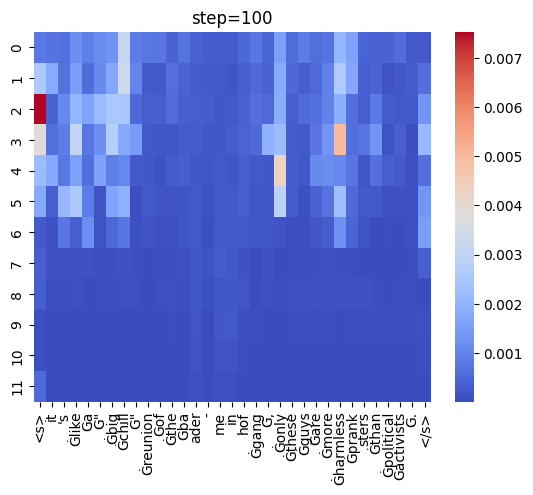

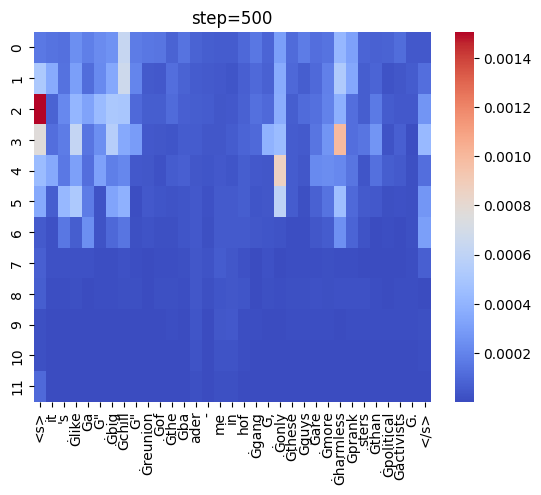

{'text': 'the story gives ample opportunity for large-scale action and suspense , which director shekhar kapur supplies with tremendous skill .', 'label': 1}
----------------------------------------


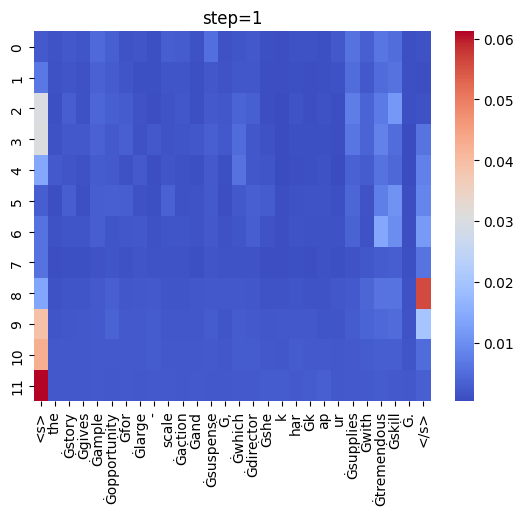

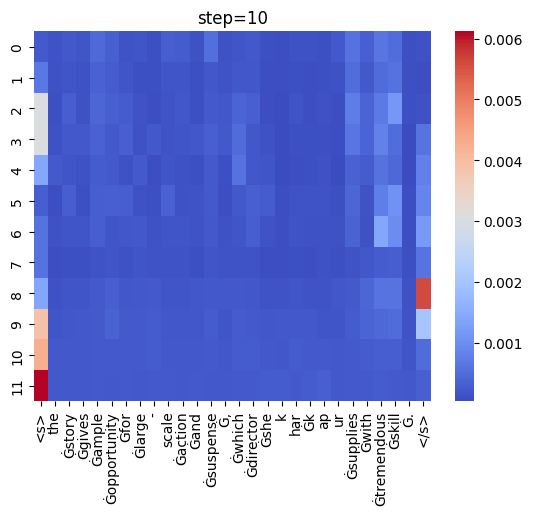

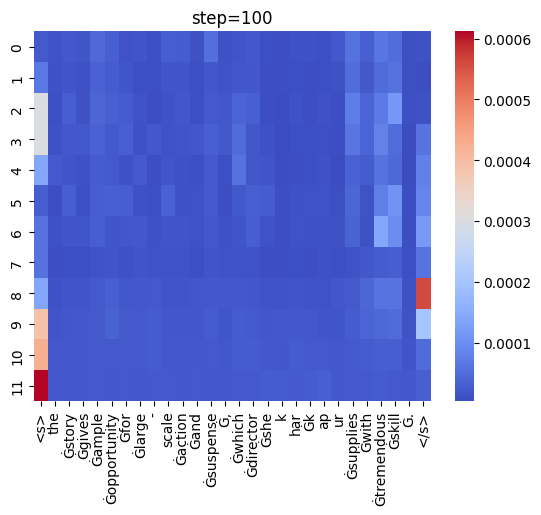

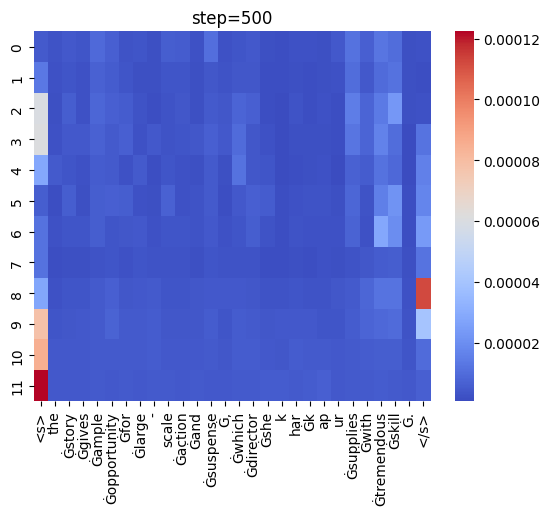

{'text': 'red dragon " never cuts corners .', 'label': 1}
----------------------------------------


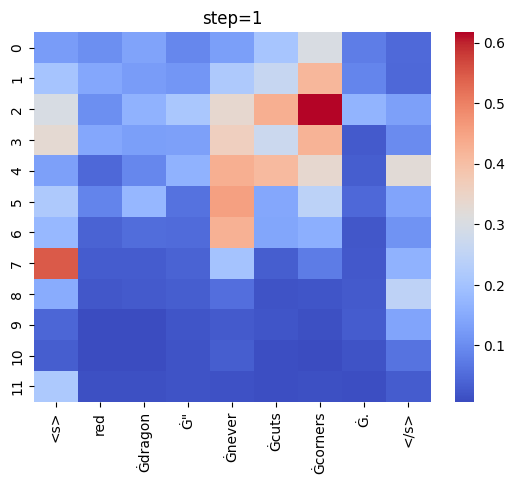

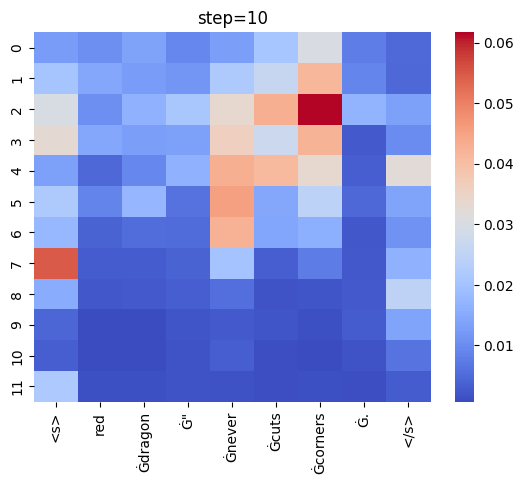

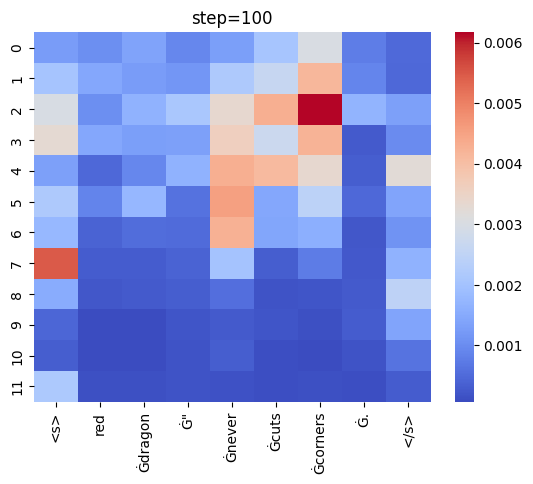

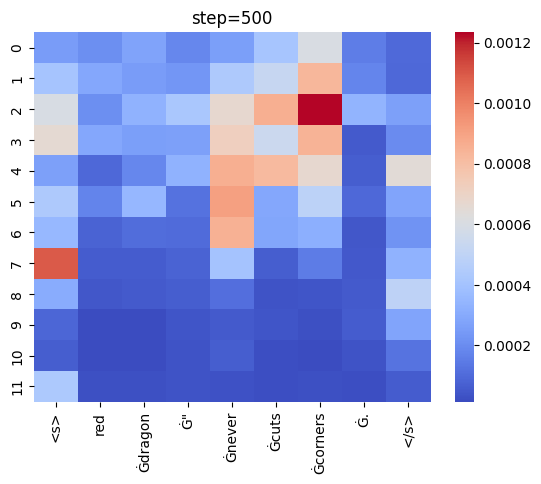

{'text': 'fresnadillo has something serious to say about the ways in which extravagant chance can distort our perspective and throw us off the path of good sense .', 'label': 1}
----------------------------------------


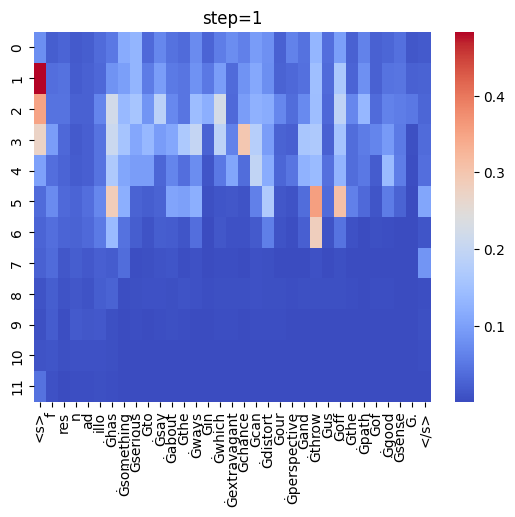

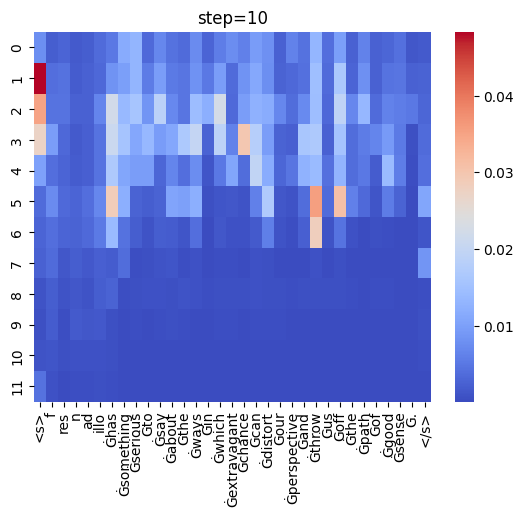

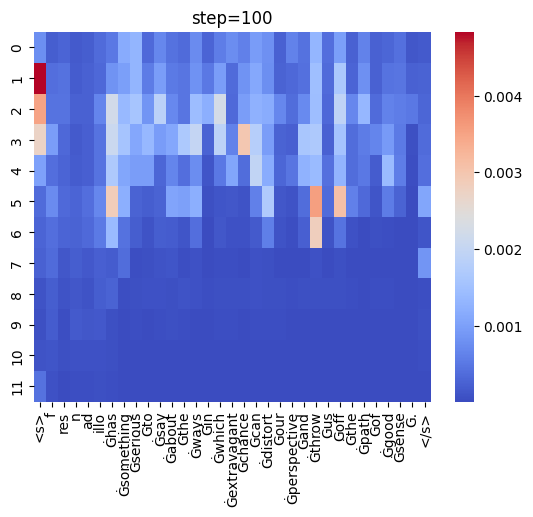

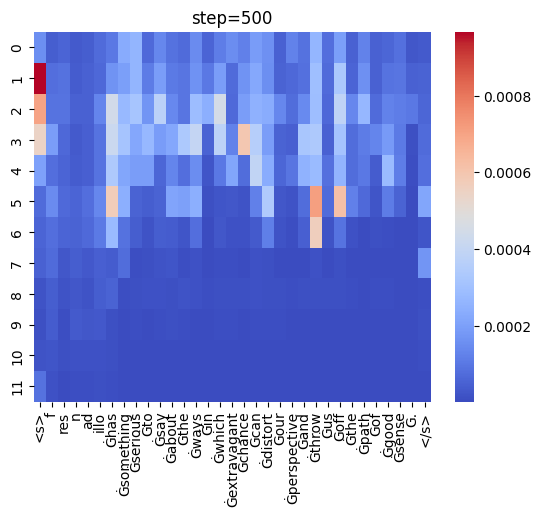

{'text': 'throws in enough clever and unexpected twists to make the formula feel fresh .', 'label': 1}
----------------------------------------


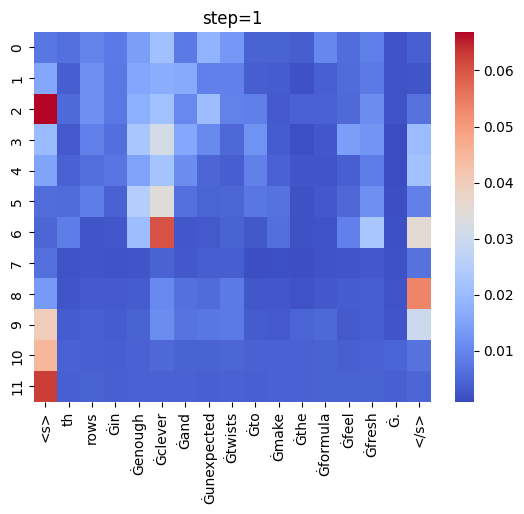

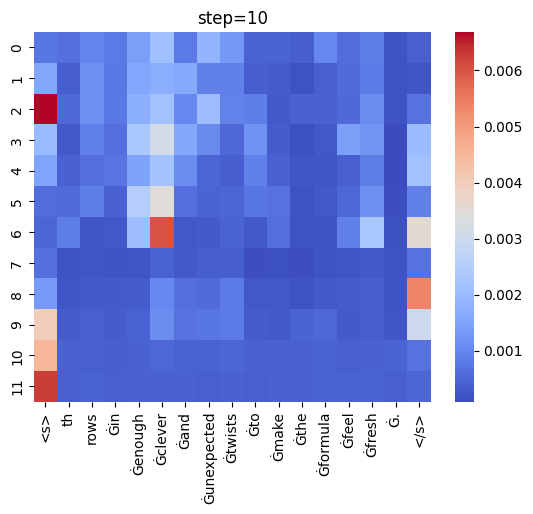

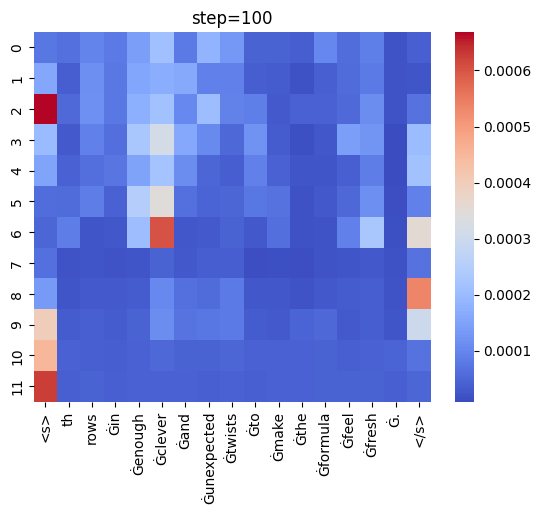

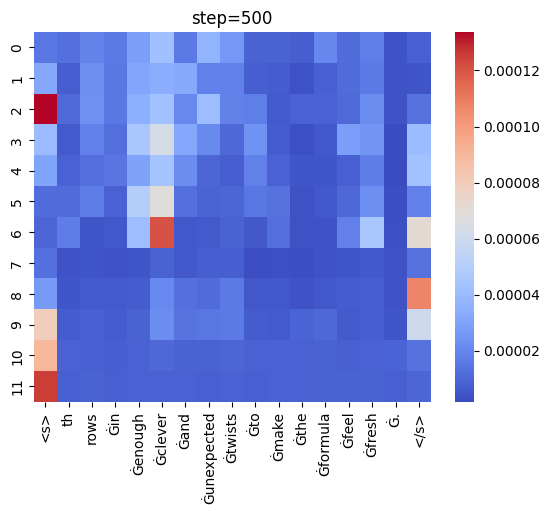

{'text': 'weighty and ponderous but every bit as filling as the treat of the title .', 'label': 1}
----------------------------------------


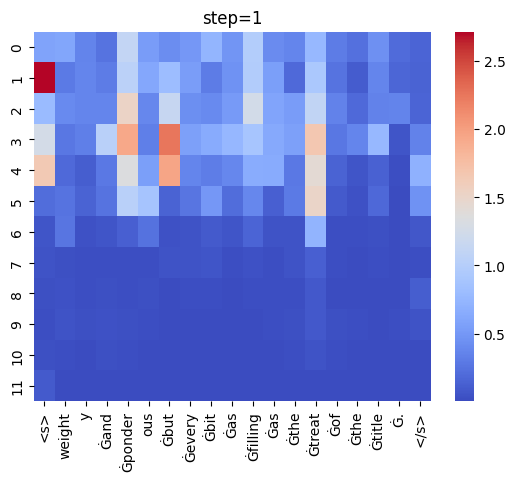

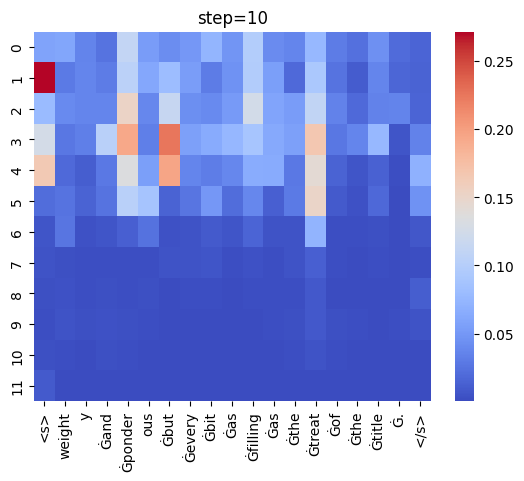

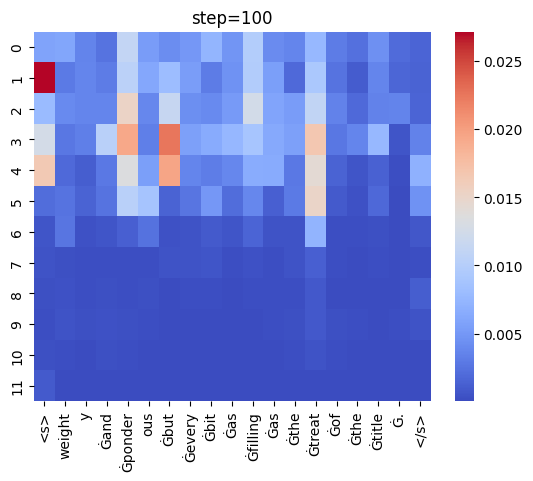

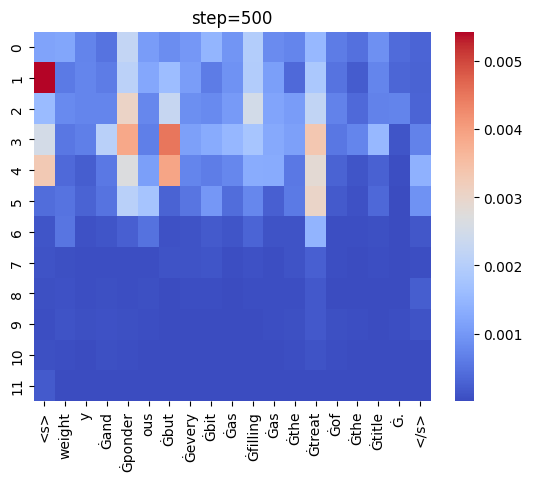

{'text': "a real audience-pleaser that will strike a chord with anyone who's ever waited in a doctor's office , emergency room , hospital bed or insurance company office .", 'label': 1}
----------------------------------------


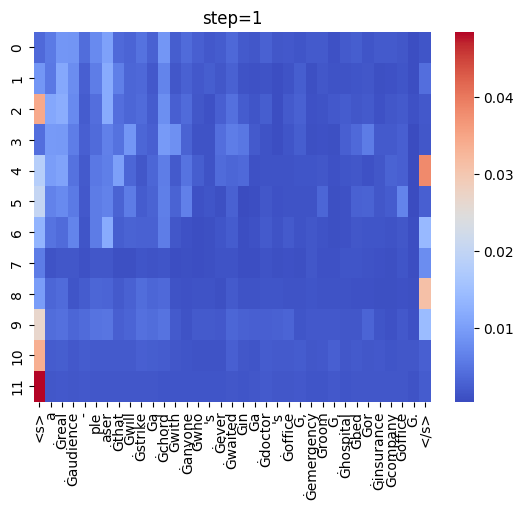

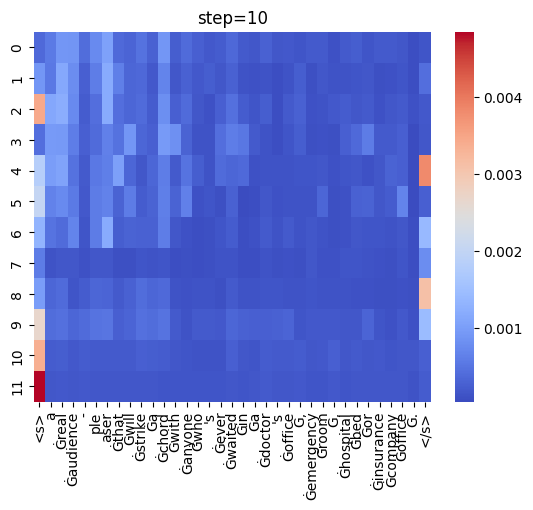

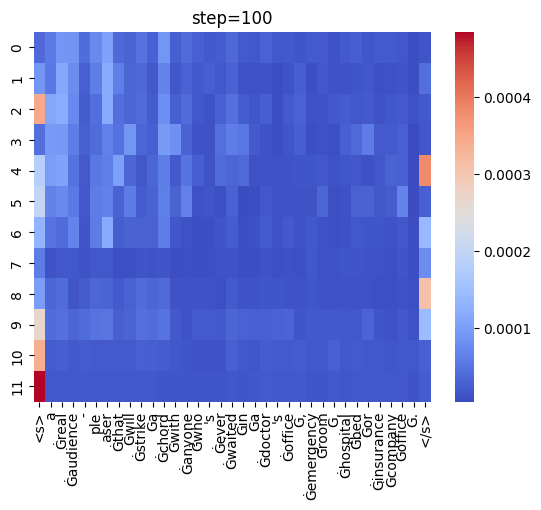

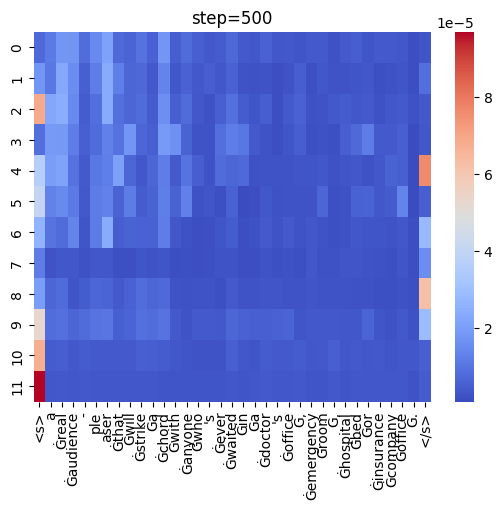

{'text': 'generates an enormous feeling of empathy for its characters .', 'label': 1}
----------------------------------------


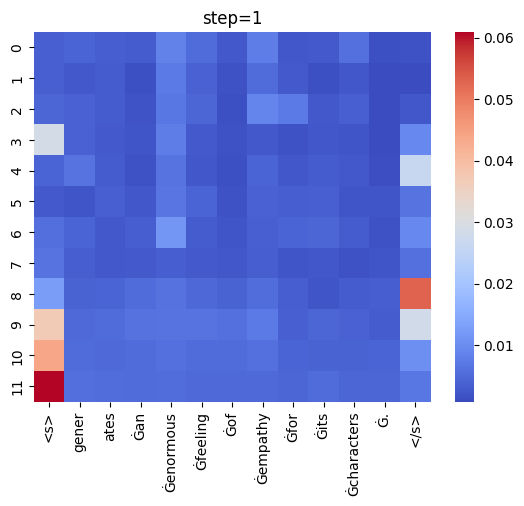

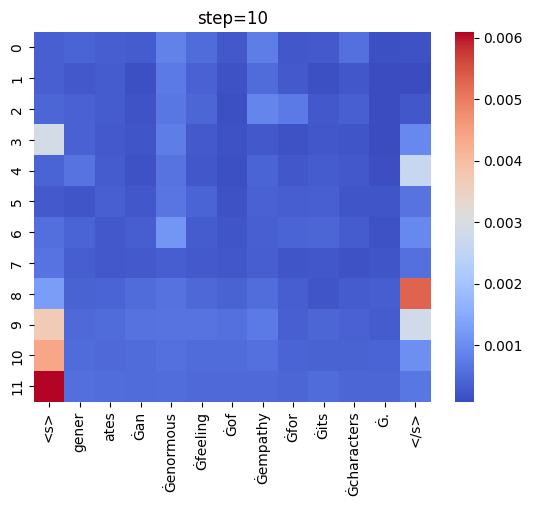

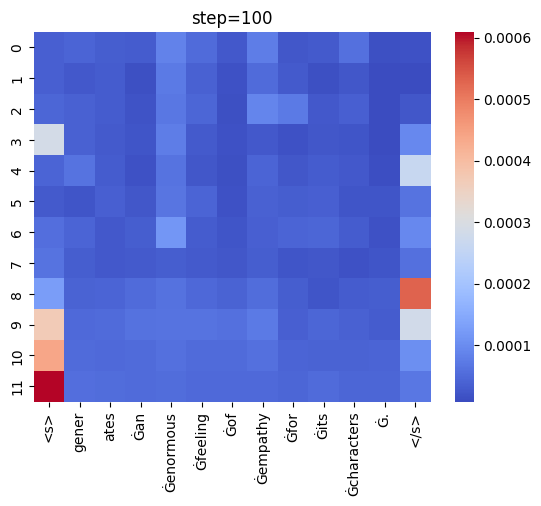

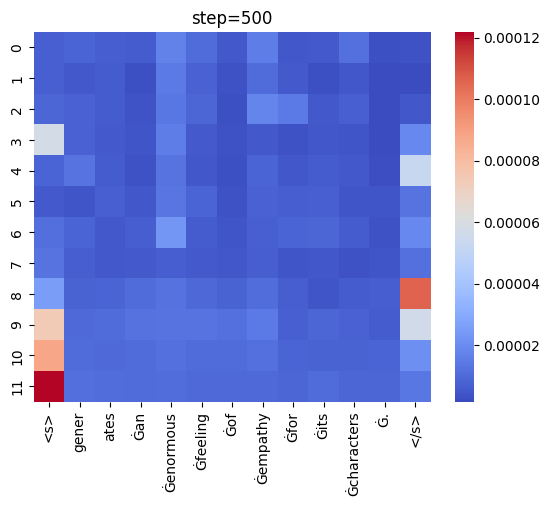

In [21]:
steps = [1, 10, 100, 500]
embed = roberta_model.roberta.embeddings

for i in tqdm(range(10)):
    print(small_test_dataset [i])
    print('-'*40)
    data = tokenizer(small_test_dataset [i]['text'], return_tensors='pt')

    embedding = embed(data['input_ids'].to(device))
    zero_data = torch.zeros_like(embedding)
    idx = small_test_dataset [i]['label']

    for j, step in enumerate(steps):
        integrated_gradients = compute_integrated_gradient(embedding, zero_data, roberta_model, idx, step)[0:12]

        # Create a PyTorch tensor
        tensor = integrated_gradients.to('cpu').detach().numpy()

        heatmap= sns.heatmap(tensor, cmap='coolwarm', xticklabels=tokenizer.convert_ids_to_tokens(data['input_ids'].squeeze()))
        heatmap.set_title(f'step={step}')

        # Show the plot
        plt.show()




